In [1]:
import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
from jax.tree_util import Partial
key = jax.random.PRNGKey(137)

import matplotlib.pyplot as plt

from scipy.spatial import KDTree
import jaxkd as jk

## Basic usage

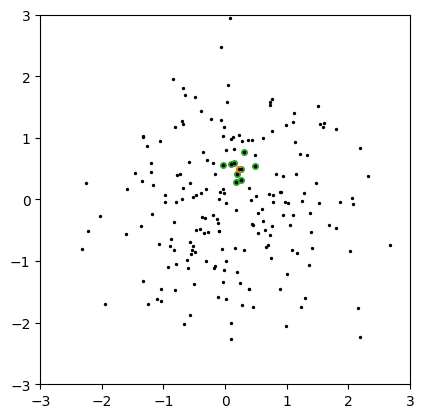

In [2]:
# Generate a few random points
n_points = 200
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, points[0], 10)

# Plot
plt.scatter(*points[neighbors].T, s=16, c='C2')
plt.scatter(*points[0], s=16, c='C1')
plt.scatter(*points.T, s=2, c='k')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

## More points, *highly* recommended to run on at GPU

In [26]:
# Test with larger number of points (run a second time to see compiled speed)
n_points = 1_000_000
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 3))
tree = jk.build_tree(points, optimize=True)
tree

tree(points=Array([[-1.5738372e+00,  1.5972906e-01, -1.5489956e+00],
       [-1.2849354e+00,  9.0706623e-01, -5.7082736e-01],
       [-6.5303862e-02,  1.8438954e+00, -3.9029440e-01],
       ...,
       [-8.4969312e-01, -4.8250869e-01, -1.2987053e+00],
       [ 3.0866340e-01,  9.8494232e-01, -7.1408920e-04],
       [ 3.0627811e-01, -6.7490655e-01, -1.0343981e+00]], dtype=float32), indices=Array([ 44607,  36815, 374857, ..., 518209,  43290, 776486], dtype=int32), split_dims=Array([ 2,  1,  0, ..., -1, -1, -1], dtype=int32))

In [28]:
# Find neighbors for all points (run a second time to see compiled speed)
neighbors, distances = jk.query_neighbors(tree, points, 4)
neighbors

Array([[     0, 169473, 121146, 104097],
       [     1, 477157, 373313, 310241],
       [     2, 420123, 387874, 548235],
       ...,
       [999997, 412452, 572014, 733032],
       [999998, 233116, 920956, 765572],
       [999999,  17747, 450187, 559016]], dtype=int32)

In [29]:
# Build scipy KDTree to compare
scipy_tree = KDTree(points)

In [30]:
# Find neighbors for all points again
scipy_neighbors = scipy_tree.query(points, k=4, workers=-1)[1]
scipy_neighbors

array([[     0, 169473, 121146, 104097],
       [     1, 477157, 373313, 310241],
       [     2, 420123, 387874, 548235],
       ...,
       [999997, 412452, 572014, 733032],
       [999998, 233116, 920956, 765572],
       [999999,  17747, 450187, 559016]], shape=(1000000, 4))

In [31]:
# Do all points match? Guessing some issues from floating point precision...
jnp.sum(neighbors == scipy_neighbors) / neighbors.size

Array(0.99999976, dtype=float32)

## Differentiation